### In this project, I will be building a recommender system of new york city job posting using machine learning techniques learned in second course in this specialization. Then next I will be using neural network to improve the model performance. The dataset is obtained from Kaggle, https://www.kaggle.com/new-york-city/new-york-city-current-job-postings.

This dataset contains current job postings available on the City of New York’s official jobs site (http://www.nyc.gov/html/careers/html/search/search.shtml). Internal postings available to city employees and external postings available to the general public are included. This is a dataset hosted by the City of New York. The city has an open data platform found here and they update their information according the amount of data that is brought in. Update Frequency: This dataset is updated weekly.

In [1]:
# Download the csv file
!wget https://raw.githubusercontent.com/dxljack/Advanced-Data-Science-with-IBM-Specialization/master/IBM%20Advanced%20Data%20Science%20Capstone/nyc-jobs.csv

Waiting for a Spark session to start...
Spark Initialization Done! ApplicationId = app-20190924055213-0003
KERNEL_ID = 2b98ec4c-4818-46a8-a29a-d82f350a20ac
--2019-09-24 05:52:16--  https://raw.githubusercontent.com/dxljack/Advanced-Data-Science-with-IBM-Specialization/master/IBM%20Advanced%20Data%20Science%20Capstone/nyc-jobs.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.8.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.8.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17412646 (17M) [text/plain]
Saving to: 'nyc-jobs.csv.3'

100%[======================================>] 17,412,646  78.7MB/s   in 0.2s   

2019-09-24 05:52:17 (78.7 MB/s) - 'nyc-jobs.csv.3' saved [17412646/17412646]



In [2]:
# Read the csv file in spark
rdd = sc.textFile('nyc-jobs.csv')
df = spark.read.csv(rdd, header=True)

### 1. Data Exploration

In [3]:
# Take a look at our dataset the first time
df.show()

+------+--------------------+------------+--------------+--------------------+--------------------+-------------+-----+--------------------+-----------------------------+-----------------+---------------+----------------+--------------------+--------------------+--------------------+-------------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+
|Job ID|              Agency|Posting Type|# Of Positions|      Business Title| Civil Service Title|Title Code No|Level|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|Salary Frequency|       Work Location|  Division/Work Unit|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|            To Apply|         Hours/Shift|     Work Location 1| Recruitment Contact|Residency Require

#### 1.1. How many jobs do we have in the dataset?

In [4]:
allJobs = df.count()
print("All rows in database: ", allJobs )

All rows in database:  3228


#### 1.2. How many distinct job title do we have in the dataset?

In [5]:
uniqueJobs = df.select('Business Title').distinct().count()
print("Total n. of distinct job titles: ", uniqueJobs)

Total n. of distinct job titles:  1326


In [6]:
# Take only columns necessary to the project
df1 = df[["Job ID", "Agency", "# Of Positions", "Business Title", "Job Category", "Full-Time/Part-Time indicator", "Salary Range From", "Salary Range To", "Work Location", "Job Description", "Minimum Qual Requirements", "Preferred Skills", "Additional Information"]]
df1.show()

+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|# Of Positions|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|       Work Location|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|             1|     Account Manager|                null|                         null|            42405|          65485| 110 William St. N Y|Division of Econo...|     "1.	A baccalau

#### 1.3. Fix some wrong data types

In [7]:
# Next we make sure that numerical columns are in type integer
from pyspark.sql.types import *
df1 = df1.withColumn("Salary Range From", df1["Salary Range From"].cast(IntegerType()))
df1 = df1.withColumn("Salary Range To", df1["Salary Range To"].cast(IntegerType()))
df1 = df1.withColumn("# Of Positions", df1["# Of Positions"].cast(IntegerType()))

In [8]:
# Change to pandas dataframe for easy visualization
df_p = df1.toPandas()
df_p.shape

(3228, 13)

#### 1.4. How many positions available for each job?

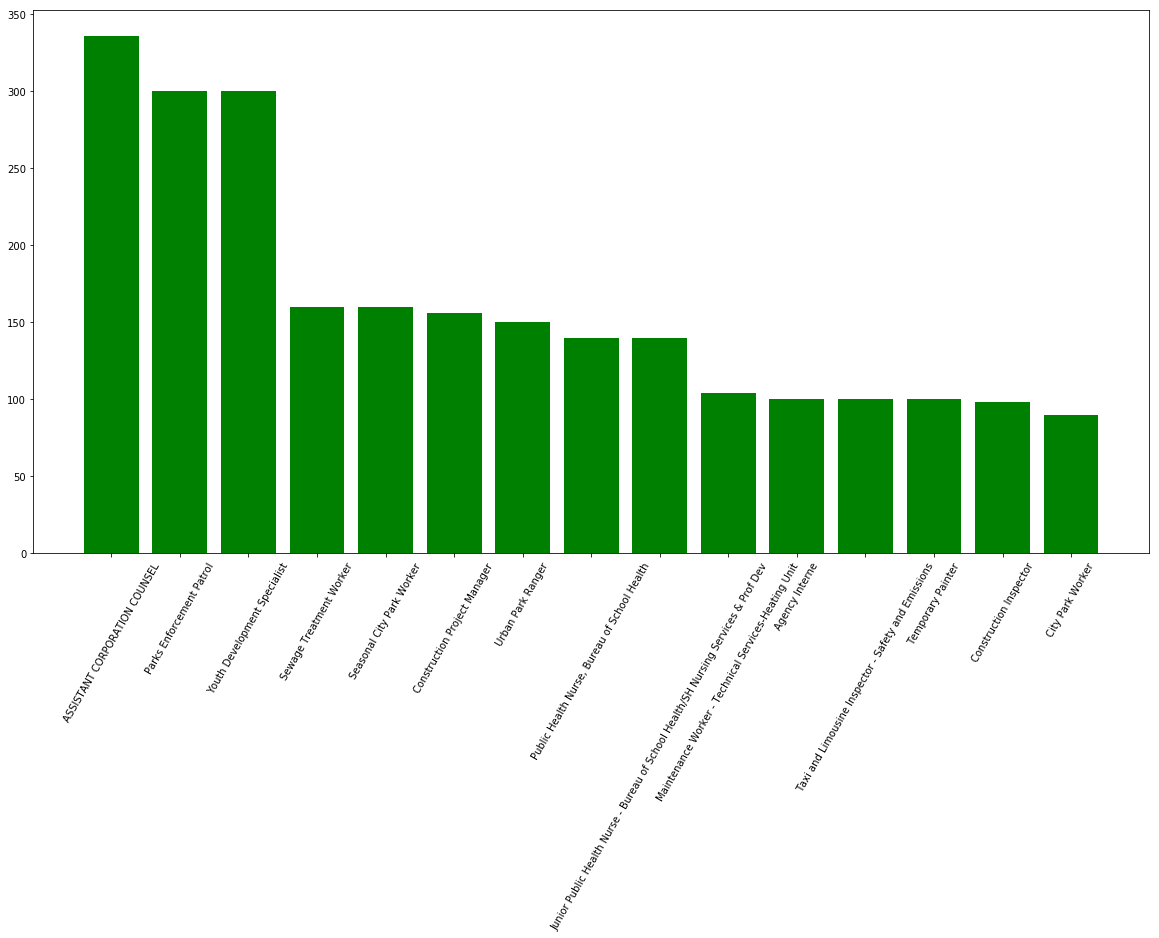

In [9]:
# Visualization on number of postions for each job
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

vacancies = df_p.groupby('Business Title')['# Of Positions'].sum().sort_values(ascending=False).head(15)
vacancies = vacancies.reset_index()

plt.figure(figsize=(20,10))
plt.bar(vacancies['Business Title'], vacancies['# Of Positions'], color='green')
plt.xticks(vacancies['Business Title'], rotation=60)
plt.show()


#### 1.5. What are the highest paid jobs in the dataset?

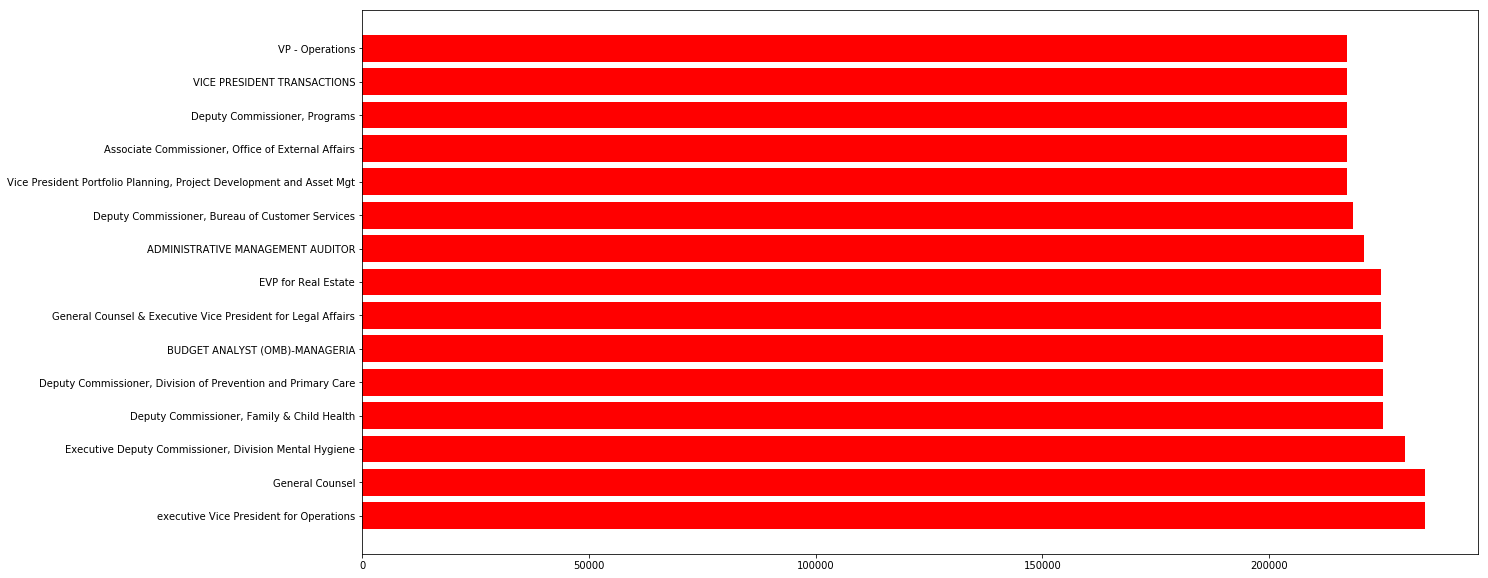

In [10]:
# Highest salary jobs
salaries = df_p.groupby('Business Title')['Salary Range To'].mean().sort_values(ascending=False).head(15)
salaries = salaries.reset_index()

plt.figure(figsize=(20,10))
plt.barh(salaries['Business Title'], salaries['Salary Range To'], color='red')
plt.yticks(salaries['Business Title'])
plt.show()

In [11]:
# Install wordcloud
!pip install wordcloud

  Using cached https://files.pythonhosted.org/packages/ae/af/849edf14d573eba9c8082db898ff0d090428d9485371cc4fe21a66717ad2/wordcloud-1.5.0-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/e5/e6/c3fdc53aed9fa19d6ff3abf97dfad768ae3afce1b7431f7500000816bda5/numpy-1.17.2-cp36-cp36m-manylinux1_x86_64.whl
  Using cached https://files.pythonhosted.org/packages/14/41/db6dec65ddbc176a59b89485e8cc136a433ed9c6397b6bfe2cd38412051e/Pillow-6.1.0-cp36-cp36m-manylinux1_x86_64.whl
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
Target directory /home/spark/shared/user-libs/python3.6/wordcloud already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/Pillow-6.1.0.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/numpy already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/us

#### 1.6. What qualifications and skills do most jobs require?

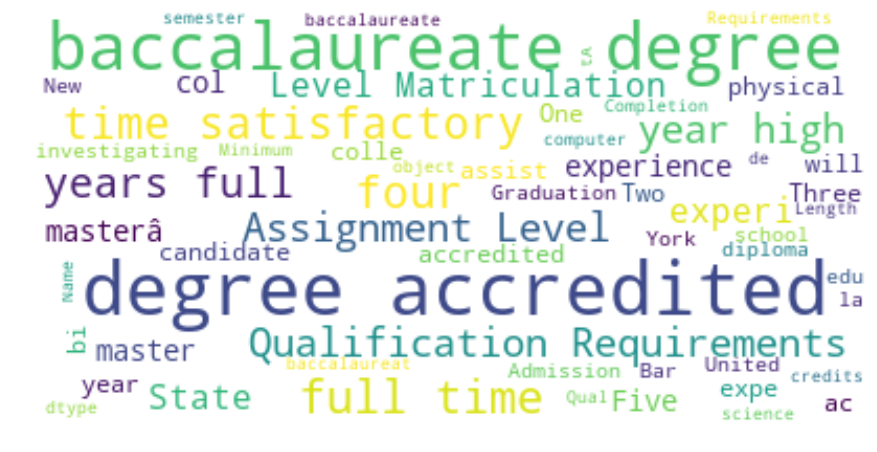

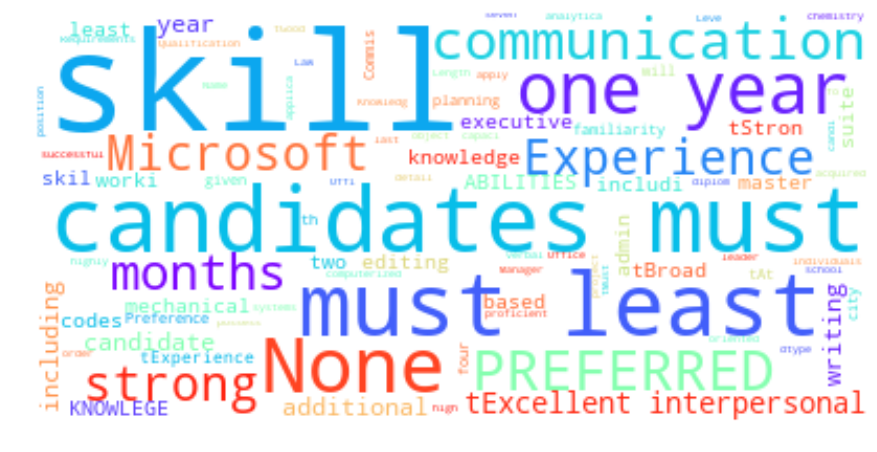

In [12]:
# Find the most occuring qualification and skill
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
stopwords = set(STOPWORDS)
stopwords.update(["english"])

# Generate a word cloud image
plt.figure(figsize=(15, 10))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", max_words=150).generate_from_text(str(df_p['Minimum Qual Requirements']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

plt.figure(figsize=(15, 10))
wordcloud = WordCloud(stopwords=stopwords, background_color="white", colormap="rainbow", max_words=150).generate_from_text(str(df_p['Preferred Skills']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### 2. Data Cleaning and Feature Engineering

#### 2.1. Create ETL, and upload the nyc-jobs.csv file to Cloud Object Storage

In [13]:
credentials = {

   "apikey": "oDF5lYbLsLQXa8RMBtucTdeT3g3yXGRYa9H3rJXBUltC",
   "cos_hmac_keys": {
    "access_key_id": "38428cff313d4390a5766378a14f9830", 
    "secret_access_key": "e77e2857559e362dc4231e72a7aec17e2ed5a8e935a5cb79"
   },
   "endpoints": "https://s3.us.cloud-object-storage.appdomain.cloud",
   "iam_apikey_description": "Auto-generated for key 38428cff-313d-4390-a576-6378a14f9830",
   "iam_apikey_name": "Service credentials-1",
   "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Manager",
   "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/39ab347da12e4d838644458813bd22dd::serviceid:ServiceId-5d306231-6364-4926-b25a-2d9394d33d4f",
  "resource_instance_id": "crn:v1:bluemix:public:cloud-object-storage:global:a/39ab347da12e4d838644458813bd22dd:abc5e98f-41d3-49c9-a285-c321a1be779c::"
}

In [14]:
endpoint = 'https://s3.us.cloud-object-storage.appdomain.cloud'

In [15]:
bucket_name = 'advanceddatasciencewithibm-donotdelete-pr-ix96rnitjjpbid'

In [16]:
from ibm_botocore.client import Config
import ibm_boto3 as boto3

In [17]:
resource = boto3.resource(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url = endpoint,
)

In [18]:
client = boto3.client(
    's3',
    aws_access_key_id = credentials["cos_hmac_keys"]['access_key_id'],
    aws_secret_access_key = credentials["cos_hmac_keys"]["secret_access_key"],
    endpoint_url=endpoint,

)

In [19]:
client.upload_file(Filename='nyc-jobs.csv',Bucket=bucket_name,Key='nyc-jobs_data.csv')

#### 2.2. Drop the column with unformatted data

In [20]:
# Next we observe the work location column has none address formatted entries
# However I don't have access to Google or Foursquare API, therefore I don't know the exact address of each location
# Since the entire dataset was about job postings within New York City, I have decided to drop the work location column
df1 = df1.drop('Work Location')

#### 2.3. Imputing some missing data

In [21]:
# Notice here that there are missing values
# Majority of missing values are not numerical, therefore I won't be able to impute them
# In addition, I cannot drop all missing values either since, it will reduce the dataset drastically
# However, I can impute the missing value for Full-Time/Part-Time indicator column

from pyspark.sql.functions import when

df1 = df1.withColumn("Full-Time/Part-Time indicator", \
              when(df1["Salary Range From"] > 2000, "F").otherwise(df1["Full-Time/Part-Time indicator"]))

df1 = df1.withColumn("Full-Time/Part-Time indicator", \
              when(df1["Salary Range From"] < 2000, "P").otherwise(df1["Full-Time/Part-Time indicator"]))

#### 2.4. Fix some wrong data types again

In [22]:
df1 = df1.withColumn("Minimum Qual Requirements", df1["Minimum Qual Requirements"].cast(StringType()))
df1 = df1.withColumn("Preferred Skills", df1["Preferred Skills"].cast(StringType()))

In [23]:
df1.show()

+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+-------------------------+--------------------+----------------------+
|Job ID|              Agency|# Of Positions|      Business Title|        Job Category|Full-Time/Part-Time indicator|Salary Range From|Salary Range To|     Job Description|Minimum Qual Requirements|    Preferred Skills|Additional Information|
+------+--------------------+--------------+--------------------+--------------------+-----------------------------+-----------------+---------------+--------------------+-------------------------+--------------------+----------------------+
| 87990|DEPARTMENT OF BUS...|             1|     Account Manager|                null|                            F|            42405|          65485|Division of Econo...|     "1.	A baccalaurea...| all candidates m...|  â€¢	Excellent int...|
| 97899|DEPARTMENT OF BUS...|   

#### 2.5. Split the columns with multiple strings into keywords separated by comma

In [24]:
# Now we do some feature engineering
# I would like to separete each requirement in minimum qual requirements column and preferred skills column and put them in one-hot encoding
# However, it seems to be impossible for this project because
# 1. the values are saparated by a mix of punctuation marks rather than commas
# 2. The number of string values in the column for each job is not the same
# What I will do here is to split them by semicolons and put them in a single list
from pyspark.sql.functions import split

df_qual = df1.withColumn("Minimum Qual Requirements", split("Minimum Qual Requirements", " "))

df_skill = df_qual.withColumn("Preferred Skills", split("Preferred Skills", " "))

#### 2.6. Extract the seemingly correlated columns and compute its correlation

In [25]:
# Focus on the minimum qual requirements and preferred skills columns
df_cor = df_skill[['Business Title', 'Salary Range From', 'Minimum Qual Requirements', 'Preferred Skills']]
df_cor.show()

+--------------------+-----------------+-------------------------+--------------------+
|      Business Title|Salary Range From|Minimum Qual Requirements|    Preferred Skills|
+--------------------+-----------------+-------------------------+--------------------+
|     Account Manager|            42405|     ["1.	A, baccalaur...|[, all, candidate...|
|EXECUTIVE DIRECTO...|            60740|     ["1., A, baccalau...|                null|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|
|   Temporary Painter|               35|     [1., Five, years,...|                null|
|   Temporary Painter|               35|     [1., Five, years,...|                null|
|    Contract Analyst|            50598|     ["1., A, baccalau...|[, individuals, m...|
|   Associate Chemist|            50623|     [Qualification, R...|[In, order, to, a...|
|Cost Estimating M...|          

In [26]:
# Count number of values in the minimum qual requirements column
from pyspark.sql.functions import size
cor1 = df_cor.select('*',size('Minimum Qual Requirements').alias('Qual Count'))

# Count number of values in the preferred skills column
cor2 = cor1.select('*',size('Preferred Skills').alias('Skills Count'))
cor2.show()

+--------------------+-----------------+-------------------------+--------------------+----------+------------+
|      Business Title|Salary Range From|Minimum Qual Requirements|    Preferred Skills|Qual Count|Skills Count|
+--------------------+-----------------+-------------------------+--------------------+----------+------------+
|     Account Manager|            42405|     ["1.	A, baccalaur...|[, all, candidate...|        71|          16|
|EXECUTIVE DIRECTO...|            60740|     ["1., A, baccalau...|                null|       140|          -1|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|        63|           2|
|Maintenance Worke...|            51907|     ["1., Three, year...|      [, mechanical]|        63|           2|
|   Temporary Painter|               35|     [1., Five, years,...|                null|        69|          -1|
|   Temporary Painter|               35|     [1., Five, years,...|                null|        69|      

In [27]:
# There are obvious data loss, since the preferred skills column has size -1
# Find correlations between salary and qual requirements/skills
# For some reason, I cannot get the matrix to display in correct format, ie. 3x3 
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import Normalizer

assembler = VectorAssembler(inputCols=["Salary Range From", "Qual Count", "Skills Count"], outputCol="vector_col")
assembled = assembler.transform(cor2).select('vector_col')
matrix = Correlation.corr(assembled, 'vector_col')
matrix.collect()[0]["pearson({})".format('vector_col')].values

array([ 1.        , -0.00607311,  0.16031597, -0.00607311,  1.        ,
       -0.08789125,  0.16031597, -0.08789125,  1.        ])

### 3. Model Training With Machine Learning

In [28]:
!pip install rake_nltk

  Using cached https://files.pythonhosted.org/packages/73/fb/00a976f728d0d1fecfe898238ce23f502a721c0ac0ecfedb80e0d88c64e9/six-1.12.0-py2.py3-none-any.whl
tensorflow 1.13.1 requires tensorboard<1.14.0,>=1.13.0, which is not installed.
Target directory /home/spark/shared/user-libs/python3.6/six.py already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/rake_nltk-1.0.4.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/nltk-3.4.5.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/six-1.12.0.dist-info already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/__pycache__ already exists. Specify --upgrade to force replacement.
Target directory /home/spark/shared/user-libs/python3.6/rake_nltk already exists. Specify --upgrade to force replacemen

In [29]:
import pandas as pd
from rake_nltk import Rake
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [30]:
model_df = df[["Job ID", "Business Title", "Job Description", "Minimum Qual Requirements", "Preferred Skills"]]

In [31]:
from pyspark.sql import functions as C

#### 3.1. Group some interested columns into one

In [32]:
model_df1 = model_df.withColumn('Joined Column', 
                    C.concat(C.col('Business Title'), C.lit(' '), C.col('Job Description'), C.lit(' '), C.col('Minimum Qual Requirements'), C.lit(' '), C.col('Preferred Skills')))
model_df1.show()

+------+--------------------+--------------------+-------------------------+--------------------+--------------------+
|Job ID|      Business Title|     Job Description|Minimum Qual Requirements|    Preferred Skills|       Joined Column|
+------+--------------------+--------------------+-------------------------+--------------------+--------------------+
| 87990|     Account Manager|Division of Econo...|     "1.	A baccalaurea...| all candidates m...|Account Manager D...|
| 97899|EXECUTIVE DIRECTO...|The New York City...|     "1. A baccalaurea...|                null|                null|
|132292|Maintenance Worke...|Under direct supe...|     "1. Three years o...|          mechanical|Maintenance Worke...|
|132292|Maintenance Worke...|Under direct supe...|     "1. Three years o...|          mechanical|Maintenance Worke...|
|133921|   Temporary Painter|Responsibilities ...|     1. Five years of ...|                null|                null|
|133921|   Temporary Painter|Responsibilities ..

#### 3.2. Convert into pandas dataframe for modeling

In [33]:
# Not sure how to add the desired column in spark dataframe 
# Here I will briefly convert it to pandas dataframe
model_dfp = model_df1.toPandas()

In [34]:
model_dfp["Joined Column"] = model_dfp["Joined Column"].astype(str) 

In [35]:
# Fix Business Title column string format
# Capitalize only on first letter of each word
model_dfp['Business Title'] = model_dfp['Business Title'].str.title()
model_dfp["Joined Column"] = model_dfp["Joined Column"].str.title()
model_dfp.head()

,Job ID,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills,Joined Column
0,87990,Account Manager,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,Account Manager Division Of Economic & Financi...
1,97899,"Executive Director, Business Development",The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,None
2,132292,Maintenance Worker - Technical Services-Heatin...,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,Maintenance Worker - Technical Services-Heatin...
3,132292,Maintenance Worker - Technical Services-Heatin...,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,Maintenance Worker - Technical Services-Heatin...
4,133921,Temporary Painter,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,None


#### 3.3. Extract keywords

In [36]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/spark/shared/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/spark/shared/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [37]:
# Initializing the new column
model_dfp['keyWords'] = ""

for index, row in model_dfp.iterrows():
    keyword = row['Joined Column']
    
    # Instantiating Rake, by default it uses english stopwords from NLTK and discards all puntuation characters as well
    r = Rake()

    # Extracting the words by passing the text
    r.extract_keywords_from_text(keyword)

    # Getting the dictionary with key words as keys and their scores as values
    key_words_dict_scores = r.get_word_degrees()
    
    # Assigning the key words to the new column
    row['keyWords'] = list(key_words_dict_scores.keys())

# Dropping the Joined Column
model_dfp.drop(columns = ['Joined Column'], inplace = True)

In [38]:
model_dfp.drop_duplicates(subset = "Business Title", inplace=True)

In [39]:
model_dfp.set_index('Business Title', inplace = True)

In [40]:
model_dfp.head()

,Job ID,Job Description,Minimum Qual Requirements,Preferred Skills,keyWords
Business Title,,,,,
Account Manager,87990,Division of Economic & Financial Opportunity (...,"""1.\tA baccalaureate degree from an accredited...",all candidates must have at least one year of...,"[defo, women, method, new, york, cityâ, €™, do..."
"Executive Director, Business Development",97899,The New York City Department of Small Business...,"""1. A baccalaureate degree from an accredited ...",None,[none]
Maintenance Worker - Technical Services-Heating Unit,132292,"Under direct supervision, assist in the routin...","""1. Three years of full-time satisfactory expe...",mechanical,"[4, 6, helper, technical, services, public, bu..."
Temporary Painter,133921,Responsibilities of selected candidates will i...,1. Five years of full-time satisfactory experi...,None,[none]
Contract Analyst,137433,** OPEN TO PERMANENT PROCUREMENT ANALYSTS ONLY...,"""1. A baccalaureate degree from an accredited ...",individuals must have,"[4, housing, infected, persons, grants, experi..."


In [41]:
model_dfp1 = model_dfp[['Job ID', 'keyWords']]
model_dfp1.head()

,Job ID,keyWords
Business Title,,
Account Manager,87990,"[defo, women, method, new, york, cityâ, €™, do..."
"Executive Director, Business Development",97899,[none]
Maintenance Worker - Technical Services-Heating Unit,132292,"[4, 6, helper, technical, services, public, bu..."
Temporary Painter,133921,[none]
Contract Analyst,137433,"[4, housing, infected, persons, grants, experi..."


In [42]:
model_dfp1['keyWords'] = model_dfp1['keyWords'].apply(', '.join)
model_dfp1.head()

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,Job ID,keyWords
Business Title,,
Account Manager,87990,"defo, women, method, new, york, cityâ, €™, dol..."
"Executive Director, Business Development",97899,none
Maintenance Worker - Technical Services-Heating Unit,132292,"4, 6, helper, technical, services, public, bui..."
Temporary Painter,133921,none
Contract Analyst,137433,"4, housing, infected, persons, grants, experie..."


#### 3.4. Training using TfidfVectorizer

In [43]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(model_dfp1['keyWords'])

In [44]:
# Generating the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [45]:
cosine_sim

array([[1.        , 0.        , 0.00524873, ..., 0.01481167, 0.01069173,
        0.00824411],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00524873, 0.        , 1.        , ..., 0.00464727, 0.00686126,
        0.0048529 ],
       ...,
       [0.01481167, 0.        , 0.00464727, ..., 1.        , 0.01961393,
        0.01341139],
       [0.01069173, 0.        , 0.00686126, ..., 0.01961393, 1.        ,
        0.01110431],
       [0.00824411, 0.        , 0.0048529 , ..., 0.01341139, 0.01110431,
        1.        ]])

#### 3.5. Recommending and Performance Evaluation

In [46]:
# Creating a Series for the job titles so they are associated to an ordered numerical list I will use in the function to match the indexes
indices = pd.Series(model_dfp1.index)

# Defining the function that takes in business title as input and returns the top 10 recommended jobs
def recommendations(title, cosine_sim = cosine_sim):
    
    # Initializing the empty list of recommended jobs
    recommended_jobs = []
    
    # Gettin the index of the job that matches the title
    idx = indices[indices == title].index[0]

    # Creating a Series with the similarity scores in descending order
    score_series = pd.Series(cosine_sim[idx]).sort_values(ascending = False)

    # Getting the indexes of the 10 most similar jobs
    top_10_indexes = list(score_series.iloc[0:10].index)
    
    # populating the list with the titles of the best 10 matching jobs
    for i in top_10_indexes:
        recommended_jobs.append(list(model_dfp1.index)[i])
        
    return recommended_jobs

In [47]:
# Test the recommender system
recommendations("Computer Programmer")

['Computer Programmer',
 'Gis Analyst',
 'E-Learning Content Developer (Per Diem)',
 'E-Learning Content Developer',
 '.Net Programmer / Analyst',
 'Application Support Reporting Specialist',
 'Body Worn Camera Analyst',
 'Mipp/Tphi Software Developer',
 'Cyber Data Engineer',
 'Dynamic Crm Developer']

In [48]:
model_dfp1.iloc[model_dfp1.index.get_loc('Gis Analyst')]['keyWords']

'complexity, option, proficient, cartography, esri, planning, enterprise, geodatabase, equivalent, among, â, €¢, maintenance, end, user, help, desk, experience, working, users, human, services, city, life, microsoft, office, suite, candidates, editors, education, emergency, communications, transformation, program, demanding, projects, minimal, supervision, full, spectrum, doitt, schools, least, addresses, 625, hours, responsibilities, performance, centralized, database, businesses, perform, special, new, york, oral, communication, skills, sustained, 100, feature, classes, year, related, computer, field, scale, esriâ, €™, represented, able, attempt, team, environment, educational, employees, twenty, transit, infrastructure, 24, 60, graduate, school, satisfactory, combination, data, entry, response, agencies, using, python, projections, cscl, 2, application, development, management, division, geospatial, custom, tools, within, automated, quality, assurance, checks, technology, leader, ma

In [49]:
# Some testing codes
model_dfp1.iloc[model_dfp1.index.get_loc('Gis Analyst')]['keyWords']
matches=len(set(model_dfp1.iloc[model_dfp1.index.get_loc('Payroll Associate')]['keyWords']) & set(model_dfp1.iloc[model_dfp1.index.get_loc('Temporary Painter')]['keyWords']))
matches

3

In [50]:
# Performance Evaluation
# Due to the nature of this project, performance evaluation will be based on relevancy levels, namely the accuracy
# Here I will define the metric to be the averge number of matching keywords of recommended jobs compare to the input job
from statistics import mean 
def accuracy(title):
    matches = []
    for job in recommendations(title):
        matches.append(len(set(model_dfp1.iloc[model_dfp1.index.get_loc(job)]['keyWords']) & set(model_dfp1.iloc[model_dfp1.index.get_loc(title)]['keyWords'])))
    return(mean(matches)/max(matches))

In [51]:
accuracy('Moda Data Scientist')

0.8999999999999999

In [52]:
# Loop through all the titles and evaluate
# The results are pretty good
# However, we can see that certain values are matching perfectly
for title in model_dfp1.index:
    print(accuracy(title))

0.8857142857142858
1.0
0.9194444444444445
1.0
0.9431818181818182
0.9545454545454546
0.8891891891891891
0.8913043478260869
0.9
0.9405405405405405
0.9542857142857143
0.8891891891891891
0.9294117647058824
0.9657142857142856
0.8594594594594595
0.9609756097560975
0.9179487179487179
0.9365853658536585
1.0
0.9864864864864865
0.8547619047619047
0.8634146341463415
0.8775000000000001
0.9714285714285714
0.9657142857142856
0.9648648648648649
0.94
0.9452380952380953
0.9142857142857143
0.918918918918919
0.8974358974358975
0.8625
0.9411764705882353
0.9764705882352942
0.9676470588235294
0.9361111111111112
0.972972972972973
0.9805555555555555
0.9575757575757576
0.9833333333333333
0.9076923076923077
0.9146341463414634
0.9394736842105263
0.9275
1.0
0.9199999999999999
0.9689655172413794
0.9925925925925926
0.9333333333333333
1.0
0.9833333333333333
0.9757575757575758
0.9666666666666666
0.9756756756756757
0.9225
0.9525
0.930952380952381
0.9447368421052631
0.95
0.8357142857142857
0.9230769230769231
0.9
0.9375

#### 3.6. Possible improvements

In [107]:
# I suspect that change all value to lowercase 
# Remove all punctuations except comma
# Remove all digits will likely to increase performace of this model
# This is due to the fact that it will simply match the keywords more precisely

### 4. Model Training With Deep Learning

In [ ]:
# I suspect that using all lower case letter will probably increase performace


#### 4.1. Combine columns into one

In [53]:
# Tried to use same setting on all keywords
# One-hot encoding will crash due to too many keywords
# Instead spliting joined column into keywords, I will split only the business title and job descrpition and minimum qual requirements columns
from pyspark.sql.functions import initcap
model_df = model_df.withColumn("Business Title", initcap("Business Title"))
model_df = model_df.withColumn("Job Description", initcap("Job Description"))
model_df = model_df.withColumn("Minimum Qual Requirements", initcap("Minimum Qual Requirements"))
model_df.show()

+------+--------------------+--------------------+-------------------------+--------------------+
|Job ID|      Business Title|     Job Description|Minimum Qual Requirements|    Preferred Skills|
+------+--------------------+--------------------+-------------------------+--------------------+
| 87990|     Account Manager|Division Of Econo...|     "1.	a Baccalaurea...| all candidates m...|
| 97899|Executive Directo...|The New York City...|     "1. A Baccalaurea...|                null|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|
|133921|   Temporary Painter|Responsibilities ...|     1. Five Years Of ...|                null|
|133921|   Temporary Painter|Responsibilities ...|     1. Five Years Of ...|                null|
|137433|    Contract Analyst|** Open To Perman...|     "1. A Baccalaurea...| individuals must...|
|138531|   Associate

In [54]:
model_df2 = model_df.withColumn('Joint', 
                    C.concat(C.col('Business Title'), C.lit(' '), C.col('Job Description'), C.lit(' '), C.col('Minimum Qual Requirements')))
model_df2.show()

+------+--------------------+--------------------+-------------------------+--------------------+--------------------+
|Job ID|      Business Title|     Job Description|Minimum Qual Requirements|    Preferred Skills|               Joint|
+------+--------------------+--------------------+-------------------------+--------------------+--------------------+
| 87990|     Account Manager|Division Of Econo...|     "1.	a Baccalaurea...| all candidates m...|Account Manager D...|
| 97899|Executive Directo...|The New York City...|     "1. A Baccalaurea...|                null|Executive Directo...|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|Maintenance Worke...|
|132292|Maintenance Worke...|Under Direct Supe...|     "1. Three Years O...|          mechanical|Maintenance Worke...|
|133921|   Temporary Painter|Responsibilities ...|     1. Five Years Of ...|                null|Temporary Painter...|
|133921|   Temporary Painter|Responsibilities ..

In [55]:
model_df2 = model_df2.withColumn("Joint", model_df2["Joint"].cast(StringType()))

In [56]:
model_df2.collect()[0][5]

'Account Manager Division Of Economic & Financial Opportunity (defo)    Mayor Michael R. Bloomberg And Sbs Are Committed To Encouraging A Competitive And Diverse New York City Business Environment By Promoting The Growth And Success Of Minority And Women-owned Companies.  New York Cityâ€™s Minority And Women-owned Business Enterprise (m/wbe) Program Is Designed To Help These Historically Underserved Groups Become More Competitive.    Job Description           The Account Manager Will Provide A Range Of Supportive Services To City Agency Purchasing Personnel And Private-sector Prime Contractors To Help Them Comply With M/wbe Utilization Goals Under Local Law 129.  The Account Manager Will Oversee A Portfolio Of Several City Agencies And Will Be Responsible For The Monitoring And Oversight Of The Strategies Which Have Been Broadly Laid Out For Agencies To Increase M/wbe Utilization.  The Primary Objective For The Account Manager Is To Help Agencies Increase The Number And Dollar Value Of

In [57]:
model_df2p = model_df2.toPandas()

In [58]:
model_df2p.head()

,Job ID,Business Title,Job Description,Minimum Qual Requirements,Preferred Skills,Joint
0,87990,Account Manager,Division Of Economic & Financial Opportunity (...,"""1.\ta Baccalaureate Degree From An Accredited...",all candidates must have at least one year of...,Account Manager Division Of Economic & Financi...
1,97899,"Executive Director, Business Development",The New York City Department Of Small Business...,"""1. A Baccalaureate Degree From An Accredited ...",None,"Executive Director, Business Development The N..."
2,132292,Maintenance Worker - Technical Services-heatin...,"Under Direct Supervision, Assist In The Routin...","""1. Three Years Of Full-time Satisfactory Expe...",mechanical,Maintenance Worker - Technical Services-heatin...
3,132292,Maintenance Worker - Technical Services-heatin...,"Under Direct Supervision, Assist In The Routin...","""1. Three Years Of Full-time Satisfactory Expe...",mechanical,Maintenance Worker - Technical Services-heatin...
4,133921,Temporary Painter,Responsibilities Of Selected Candidates Will I...,1. Five Years Of Full-time Satisfactory Experi...,None,Temporary Painter Responsibilities Of Selected...


In [59]:
model_df2p["Joint"] = model_df2p["Joint"].astype(str) 

#### 4.2. Remove all punctuations and numbers

In [60]:
import string
from string import digits

def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

def remove_numbers(text):
    for number in digits:
        text = text.replace(number, '')
    return text

In [61]:
model_df2p["Joint"] = model_df2p["Joint"].apply(remove_punctuations)
model_df2p["Joint"] = model_df2p["Joint"].apply(remove_numbers)

In [62]:
model_df3p = model_df2p[['Business Title', 'Joint']]
model_df3p.head()

,Business Title,Joint
0,Account Manager,Account Manager Division Of Economic Financia...
1,"Executive Director, Business Development",Executive Director Business Development The Ne...
2,Maintenance Worker - Technical Services-heatin...,Maintenance Worker Technical Servicesheating ...
3,Maintenance Worker - Technical Services-heatin...,Maintenance Worker Technical Servicesheating ...
4,Temporary Painter,Temporary Painter Responsibilities Of Selected...


In [63]:
# Replace space with comma
model_df3p['Joint'] = model_df3p['Joint'].apply(lambda x: x.replace(' ',','))

/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [64]:
model_df3p.head()

,Business Title,Joint
0,Account Manager,"Account,Manager,Division,Of,Economic,,Financia..."
1,"Executive Director, Business Development","Executive,Director,Business,Development,The,Ne..."
2,Maintenance Worker - Technical Services-heatin...,"Maintenance,Worker,,Technical,Servicesheating,..."
3,Maintenance Worker - Technical Services-heatin...,"Maintenance,Worker,,Technical,Servicesheating,..."
4,Temporary Painter,"Temporary,Painter,Responsibilities,Of,Selected..."


In [65]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils
from keras.preprocessing.text import Tokenizer
from keras import metrics

from pprint import pprint
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

Using TensorFlow backend.
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/ibm/conda/miniconda3.6/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/ibm/conda/miniconda3.6/lib/python3.6

#### 4.3. Split data to train and test

In [82]:
train, test = train_test_split(model_df3p, test_size = 0.2)

train_Title = train['Business Title']
train_Joint = train['Joint']

test_Title = test['Business Title']
test_Joint = test['Joint']

print(len(model_df3p['Business Title'].unique().tolist()))
print(len(model_df3p['Joint'].unique().tolist()))

print(len(train_Joint.unique().tolist()))
print(len(test_Joint.unique().tolist()))

1282
1739
1618
575


In [83]:
num_labels = len(train_Title.unique().tolist())
vocab_size = 1000
batch_size = 32
nb_epoch = 30

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_Joint)
 
x_train = tokenizer.texts_to_matrix(train_Joint, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_Joint, mode='tfidf')
 
encoder = LabelBinarizer()
encoder.fit(train_Title)
y_train = encoder.transform(train_Title)
y_test = encoder.transform(test_Title)

#### 4.4. Define model

In [84]:
model = Sequential()
model.add(Dense(512, input_shape=(vocab_size,)))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.3))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
model.summary()
 
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'adam',
              metrics = [metrics.categorical_accuracy, 'accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               512512    
_________________________________________________________________
activation_4 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 512)               262656    
_________________________________________________________________
activation_5 (Activation)    (None, 512)               0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1193)              612009    
__________

In [85]:
model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    verbose=1,
                    validation_split=0.1)

Train on 2323 samples, validate on 259 samples
Epoch 1/30
2323/2323 [==============================] - 3s 1ms/step - loss: 6.7702 - categorical_accuracy: 0.0598 - acc: 0.0598 - val_loss: 6.1126 - val_categorical_accuracy: 0.1351 - val_acc: 0.1351
Epoch 2/30
2323/2323 [==============================] - 2s 680us/step - loss: 4.5367 - categorical_accuracy: 0.2622 - acc: 0.2622 - val_loss: 4.7335 - val_categorical_accuracy: 0.2741 - val_acc: 0.2741
Epoch 3/30
2323/2323 [==============================] - 2s 681us/step - loss: 2.1734 - categorical_accuracy: 0.5889 - acc: 0.5889 - val_loss: 3.5087 - val_categorical_accuracy: 0.5212 - val_acc: 0.5212
Epoch 4/30
2323/2323 [==============================] - 2s 693us/step - loss: 1.0835 - categorical_accuracy: 0.7598 - acc: 0.7598 - val_loss: 3.1457 - val_categorical_accuracy: 0.6216 - val_acc: 0.6216
Epoch 5/30
2323/2323 [==============================] - 2s 653us/step - loss: 0.6706 - categorical_accuracy: 0.8480 - acc: 0.8480 - val_loss: 3.105

#### 4.5. Evaluation metrics

In [86]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

646/646 [==============================] - 0s 100us/step
Test loss: 1.179626505819184
Test accuracy: 0.6749226006191951


#### 4.6.  Improve our model

In [92]:
train, test = train_test_split(model_df3p, test_size = 0.2)

train_Title = train['Business Title']
train_Joint = train['Joint']

test_Title = test['Business Title']
test_Joint = test['Joint']

print(len(model_df3p['Business Title'].unique().tolist()))
print(len(model_df3p['Joint'].unique().tolist()))

print(len(train_Joint.unique().tolist()))
print(len(test_Joint.unique().tolist()))

1282
1739
1614
584


In [100]:
num_labels = len(train_Title.unique().tolist())
vocab_size = 1000
batch_size = 32
nb_epoch = 50

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(train_Joint)
 
x_train = tokenizer.texts_to_matrix(train_Joint, mode='tfidf')
x_test = tokenizer.texts_to_matrix(test_Joint, mode='tfidf')
 
encoder = LabelBinarizer()
encoder.fit(train_Title)
y_train = encoder.transform(train_Title)
y_test = encoder.transform(test_Title)

In [101]:
model = Sequential()
model.add(Dense(4096, input_shape=(vocab_size,), activation = 'relu', kernel_initializer = 'glorot_normal', kernel_constraint=maxnorm(2)))
model.add(Dropout(0.1))
model.add(Dense(1024, kernel_initializer = 'glorot_normal', activation= 'relu'))
model.add(Dropout(0.1))
model.add(Dense(num_labels))
model.add(Activation('softmax'))
    
model.compile(loss = 'categorical_crossentropy',
              optimizer = 'sgd',
              metrics = [metrics.categorical_accuracy, 'accuracy'])

In [102]:
report = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=nb_epoch,
                    verbose=1,
                    validation_split=0.1)

Train on 2323 samples, validate on 259 samples
Epoch 1/50
2323/2323 [==============================] - 6s 3ms/step - loss: 7.0114 - categorical_accuracy: 0.0185 - acc: 0.0185 - val_loss: 6.8195 - val_categorical_accuracy: 0.0425 - val_acc: 0.0425
Epoch 2/50
2323/2323 [==============================] - 5s 2ms/step - loss: 6.4917 - categorical_accuracy: 0.0740 - acc: 0.0740 - val_loss: 6.5442 - val_categorical_accuracy: 0.0888 - val_acc: 0.0888
Epoch 3/50
2323/2323 [==============================] - 5s 2ms/step - loss: 5.9924 - categorical_accuracy: 0.1154 - acc: 0.1154 - val_loss: 6.2891 - val_categorical_accuracy: 0.1274 - val_acc: 0.1274
Epoch 4/50
2323/2323 [==============================] - 5s 2ms/step - loss: 5.4893 - categorical_accuracy: 0.1851 - acc: 0.1851 - val_loss: 6.0684 - val_categorical_accuracy: 0.1622 - val_acc: 0.1622
Epoch 5/50
2323/2323 [==============================] - 5s 2ms/step - loss: 4.9655 - categorical_accuracy: 0.2678 - acc: 0.2678 - val_loss: 5.8123 - val_

In [103]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
 
print('Test loss:', score[0])
print('Test accuracy:', score[1])

646/646 [==============================] - 0s 403us/step
Test loss: 0.9361288374053436
Test accuracy: 0.7554179568408812


In [104]:
print(report.history.keys())

dict_keys(['val_loss', 'val_categorical_accuracy', 'val_acc', 'loss', 'categorical_accuracy', 'acc'])


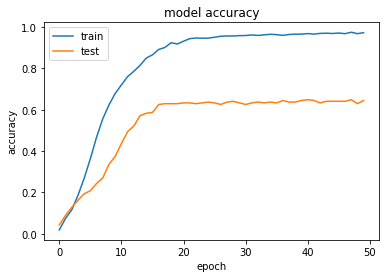

In [105]:
plt.plot(report.history['acc'])
plt.plot(report.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

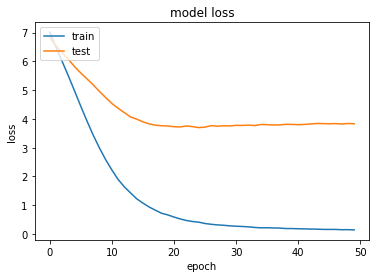

In [106]:
plt.plot(report.history['loss'])
plt.plot(report.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [108]:
# As shown in the plots we can see as epoch increases, the accuracy increases and stabilizes around 50 epochs
# This increased the model performace fairly but not extensively
# This project is yet to be finished

### 5. References

#### https://heartbeat.fritz.ai/recommender-systems-with-python-part-i-content-based-filtering-5df4940bd831
#### https://towardsdatascience.com/creating-a-hybrid-content-collaborative-movie-recommender-using-deep-learning-cc8b431618af
#### https://www.datacamp.com/community/tutorials/recommender-systems-python